In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from tqdm import tqdm
import torchvision.datasets as dset
import torchvision.transforms as T
from Plant_NN import Plant_NN, Flatten
import torch.nn.functional as F
import numpy as np

In [5]:
def collate_fn(batch):
    all_images, all_labels = [], []
    for item in batch:
        image = item.image
        label = item.label
        
        all_images.append(item.image.tolist())
        all_labels.append(label)
        
    return { 
        "images": torch.tensor(all_images),
        "labels": torch.tensor(all_labels, dtype=torch.int8)
    }

In [2]:

"""

LOAD DATASET


"""
from addict import Dict
from Dataset import PlantDiseaseDataset
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
image_target_shape = (256, 256)
image_dim = image_target_shape[0] * image_target_shape[1]

config = Dict({
    "train_path": "../dataset/Train/Train",
    "test_path": "../dataset/Test/Test",
    "validation_path": "../dataset/Validation/Validation"
})

train_config = Dict({
    "image_shape": image_target_shape,
    "image_channels": 3,
    "num_workers": 0,
    "batch_size": 32,

    "augmentations": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.Blur(p=1),
        ToTensorV2(),
    ]),
    "optimizer": {
        "type": "AdamW",
        "parameters": {
            "lr": 0.001,
            "weight_decay": 0.01,
        }
    },
    
    "scheduler": {
        "type": "ReduceLROnPlateau",
        "parameters": {
            "patience": 2,
            "mode": "min",
            "factor": 0.1,
        }
    }
})


In [3]:
select_p = 1
train_dataset = PlantDiseaseDataset(path=config.train_path, select_p=select_p,
                                    image_shape=train_config.image_shape, 
                                    channels=train_config.image_channels)

validation_dataset = PlantDiseaseDataset(path=config.validation_path, 
                                         augmentations=train_config.augmentations,
                                         image_shape=train_config.image_shape, 
                                         channels=train_config.image_channels)

test_dataset = PlantDiseaseDataset(path=config.test_path, 
                                   augmentations=train_config.augmentations,
                                   image_shape=train_config.image_shape, 
                                   channels=train_config.image_channels)

In [6]:
loader_train = DataLoader(dataset=train_dataset, 
                          batch_size=train_config.batch_size, 
                          num_workers=train_config.num_workers, 
                          pin_memory=True, 
                          shuffle=True, 
                          collate_fn=collate_fn)

validation_loader = DataLoader(dataset=validation_dataset, 
                               batch_size=train_config.batch_size*2, 
                               num_workers=train_config.num_workers, 
                               pin_memory=True, 
                               shuffle=False, 
                               collate_fn=collate_fn)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=train_config.batch_size*2, 
                         num_workers=train_config.num_workers, 
                         pin_memory=True, 
                         shuffle=False, 
                         collate_fn=collate_fn)

# Analysis

In [16]:
import seaborn as sns

In [18]:
def hide_spines(ax, spines=["top", "right", "left", "bottom"]):
    for spine in spines:
        ax.spines[spine].set_visible(False)

<Figure size 720x360 with 0 Axes>

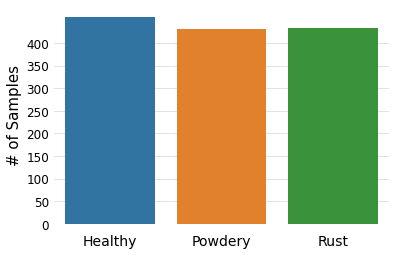

In [43]:
label_pathes = [os.path.join(config.train_path, label) for label in train_dataset.labels]
label_files = [os.listdir(path) for path in label_pathes]
amount = [len(files) for files in label_files]

# palette = sns.color_palette(["#5FB924", "#AB4800", "#B2BBAC"])
fig = plt.figure(figsize=(10, 5))
fig = plt.figure()
ax = fig.add_subplot()
ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
# sns.barplot(x=train_dataset.labels, y=amount, palette=palette,  ec="#000", linewidth=1.5, zorder=2, ax=ax)
sns.barplot(x=train_dataset.labels, y=amount, linewidth=1.5, zorder=2, ax=ax)
ax.xaxis.set_tick_params(labelsize=14, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.set_yticks(list(range(0, 450, 50)))
# ax.set_title(f"Classes Distribution", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.01)
# ax.set_xlabel("Classes", fontsize=15, fontfamily="serif", labelpad=5)
ax.set_ylabel("# of Samples", fontsize=15)
hide_spines(ax)
plt.savefig("../fig/data_dist.png", dpi=600)
# fig.show()

<Figure size 720x360 with 0 Axes>

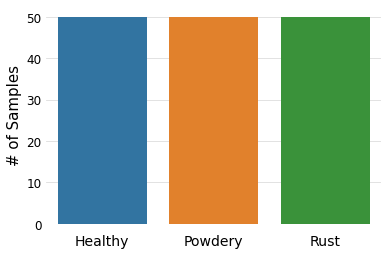

In [42]:
label_pathes = [os.path.join(config.test_path, label) for label in test_dataset.labels]
label_files = [os.listdir(path) for path in label_pathes]
amount = [len(files) for files in label_files]

# palette = sns.color_palette(["#5FB924", "#AB4800", "#B2BBAC"])
fig = plt.figure(figsize=(10, 5))
fig = plt.figure()
ax = fig.add_subplot()
ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
# sns.barplot(x=train_dataset.labels, y=amount, palette=palette,  ec="#000", linewidth=1.5, zorder=2, ax=ax)
sns.barplot(x=test_dataset.labels, y=amount, linewidth=1.5, zorder=2, ax=ax)
ax.xaxis.set_tick_params(labelsize=14, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.set_yticks(list(range(0, 60, 10)))
# ax.set_title(f"Classes Distribution", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.01)
# ax.set_xlabel("Classes", fontsize=15, fontfamily="serif", labelpad=5)
ax.set_ylabel("# of Samples", fontsize=15)
hide_spines(ax)
plt.savefig("../fig/data_dist_test.png", dpi=600)
# fig.show()

In [60]:
def plot_images(rows, cols,out_name, class_=0):
    n = rows * cols
    fig = plt.figure(figsize=(3*cols, 3*rows))
    cnt  = 0
    for i in range(len(train_dataset)):
        item = train_dataset[i]
        label = item.label
        if label == class_:
            
            image = item.image
            ax = fig.add_subplot(rows, cols, cnt+1)
            ax.imshow(image.permute(1, 2, 0))
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            cnt += 1
        if cnt >= n:
            break

#     fig.text(s=f"{train_dataset.labels[class_]} leaves", x=0.125, y=0.9, fontweight="bold", fontfamily="serif", fontsize=20)
#     plt.ylabel("")
    fig.savefig("../fig/{0}".format(out_name), dpi=600)
    fig.show()

<ipython-input-60-1cad37bf076e>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


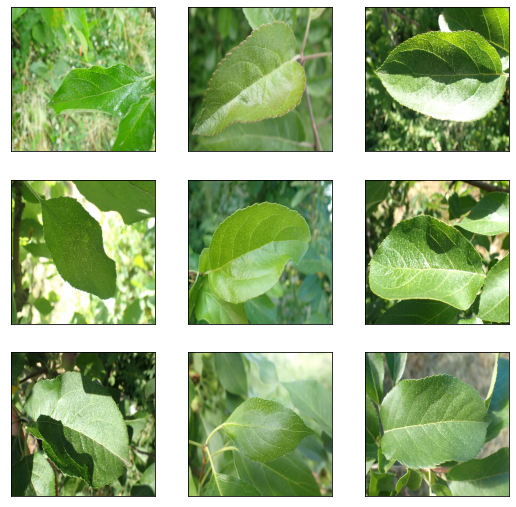

In [61]:
plot_images(rows=3, cols=3, out_name="train_samples_healthy.png", class_=0)

<ipython-input-60-1cad37bf076e>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


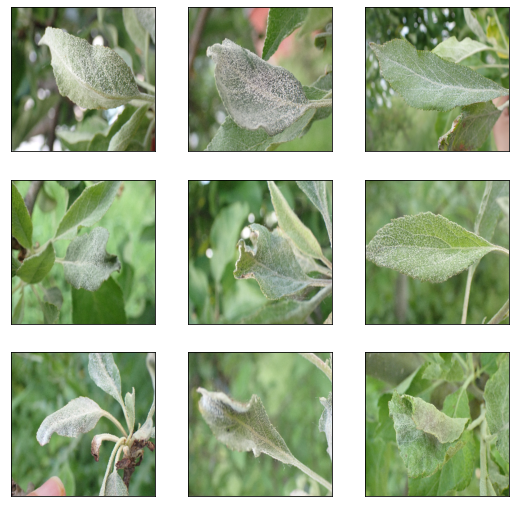

In [62]:
plot_images(rows=3, cols=3, out_name="train_samples_powdery.png", class_=1)

<ipython-input-60-1cad37bf076e>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


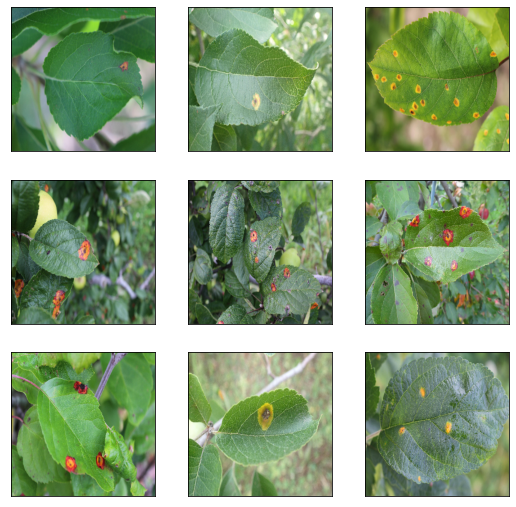

In [63]:
plot_images(rows=3, cols=3, out_name="train_samples_rust.png", class_=2)